# Advanced Model Optimization for Fraud Detection

This notebook implements several strategies to improve the ROC-AUC score beyond 0.8529:

1. **Advanced Feature Engineering** - Time-based features, polynomial features, aggregations
2. **Hyperparameter Optimization** - Using Optuna for automated tuning
3. **Better Class Imbalance Handling** - SMOTE, adjusted class weights
4. **Model Ensembling** - Stacking multiple models
5. **Threshold Optimization** - Finding optimal classification threshold

**Current Best Score:** ROC-AUC = 0.8529 (XGBoost Validation)  
**Target:** ROC-AUC > 0.95

In [5]:
import os
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Models
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

# Preprocessing and Feature Engineering
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek

# Metrics
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score, 
    f1_score, classification_report, confusion_matrix, roc_curve
)

# Hyperparameter Optimization
import optuna
from optuna.integration import LightGBMPruningCallback

# Ensemble
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

print("All libraries imported successfully!")

All libraries imported successfully!


## 1. Load Data and Initial Setup

In [ ]:
working_directory = os.getcwd()
print(f"Working directory: {working_directory}")

# Load the data
data = pd.read_csv(f"{working_directory}/Input_Data/creditcard_post_correlation.csv")

print(f"Dataset shape: {data.shape}")
print(f"Fraud cases: {data['Fraud_Flag'].sum()} ({data['Fraud_Flag'].mean()*100:.2f}%)")
print(f"Legitimate cases: {(data['Fraud_Flag']==0).sum()} ({(data['Fraud_Flag']==0).mean()*100:.2f}%)")

c:\Users\teovr\Desktop\Projects\Predicting_Fraudulent_Transactions_With_Machine_Learning
Dataset shape: (284807, 32)
Fraud cases: 492 (0.17%)
Legitimate cases: 284315 (99.83%)


## 2. Advanced Feature Engineering

Creating new features that can help the model better distinguish fraudulent transactions:
- **Time-based features**: Hour of day, day of week patterns
- **Transaction amount features**: Log transformation, binning, z-scores
- **Statistical features**: Rolling statistics, interactions
- **Polynomial features**: For top important features

In [7]:
def create_advanced_features(df):
    """Create advanced features for fraud detection"""
    df_new = df.copy()
    
    # 1. Time-based features
    # Convert seconds to hours (0-23)
    df_new['Transaction_Hour'] = (df_new['Transaction_Time'] % 86400) / 3600
    df_new['Transaction_Hour_Sin'] = np.sin(2 * np.pi * df_new['Transaction_Hour'] / 24)
    df_new['Transaction_Hour_Cos'] = np.cos(2 * np.pi * df_new['Transaction_Hour'] / 24)
    
    # Day of the data collection (assuming 48 hours of data)
    df_new['Transaction_Day'] = (df_new['Transaction_Time'] / 86400).astype(int)
    
    # Time periods (night: 0-6, morning: 6-12, afternoon: 12-18, evening: 18-24)
    df_new['Time_Period'] = pd.cut(df_new['Transaction_Hour'], 
                                     bins=[0, 6, 12, 18, 24], 
                                     labels=[0, 1, 2, 3], 
                                     include_lowest=True).astype(int)
    
    # 2. Transaction Amount features
    df_new['Amount_Log'] = np.log1p(df_new['Transaction_Amount'])
    df_new['Amount_Sqrt'] = np.sqrt(df_new['Transaction_Amount'])
    df_new['Amount_Squared'] = df_new['Transaction_Amount'] ** 2
    
    # Z-score of amount
    df_new['Amount_Zscore'] = (df_new['Transaction_Amount'] - df_new['Transaction_Amount'].mean()) / df_new['Transaction_Amount'].std()
    
    # Amount binning
    df_new['Amount_Bin'] = pd.qcut(df_new['Transaction_Amount'], q=10, labels=False, duplicates='drop')
    
    # 3. Interaction features between top V features and amount
    # Based on typical feature importance: V14, V17, V12, V10, V16 are usually important
    important_features = ['V14', 'V17', 'V12', 'V10', 'V16', 'V4', 'V11']
    
    for feat in important_features:
        if feat in df_new.columns:
            df_new[f'{feat}_x_Amount'] = df_new[feat] * df_new['Transaction_Amount']
            df_new[f'{feat}_x_Hour'] = df_new[feat] * df_new['Transaction_Hour']
    
    # 4. Statistical features for V columns
    v_columns = [col for col in df_new.columns if col.startswith('V')]
    
    # Mean and std of all V features per transaction
    df_new['V_Mean'] = df_new[v_columns].mean(axis=1)
    df_new['V_Std'] = df_new[v_columns].std(axis=1)
    df_new['V_Max'] = df_new[v_columns].max(axis=1)
    df_new['V_Min'] = df_new[v_columns].min(axis=1)
    df_new['V_Range'] = df_new['V_Max'] - df_new['V_Min']
    
    # 5. Negative and positive V features count
    df_new['V_Negative_Count'] = (df_new[v_columns] < 0).sum(axis=1)
    df_new['V_Positive_Count'] = (df_new[v_columns] > 0).sum(axis=1)
    
    print(f"Original features: {df.shape[1]}")
    print(f"New features created: {df_new.shape[1] - df.shape[1]}")
    print(f"Total features: {df_new.shape[1]}")
    
    return df_new

# Create advanced features
data_engineered = create_advanced_features(data)
data_engineered.head()

Original features: 32
New features created: 31
Total features: 63


,Transaction_Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V4_x_Hour,V11_x_Amount,V11_x_Hour,V_Mean,V_Std,V_Max,V_Min,V_Range,V_Negative_Count,V_Positive_Count
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.000000,-82.530322,-0.000000,-0.902894,40.160887,206.199585,-92.435364,298.634949,16,19
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,0.000000,4.338235,0.000000,0.308385,0.905908,4.338235,-0.638672,4.976907,16,19
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.000105,236.473723,0.000173,-5.996988,188.715680,420.301005,-1094.358902,1514.659907,17,25
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.000240,-27.971177,-0.000063,-8.873427,29.183862,22.011186,-130.866435,152.877621,29,13
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.000224,-57.590773,-0.000457,-1.432876,19.537744,52.707679,-78.365692,131.073371,19,23


## 3. Prepare Train/Validation/Test Splits

Using **stratified** splits to maintain fraud ratio across all sets.

In [8]:
# Define target and predictors
target = 'Fraud_Flag'
exclude_cols = ['Fraud_Flag']
predictors = [col for col in data_engineered.columns if col not in exclude_cols]

print(f"Total predictors: {len(predictors)}")

# Constants
TEST_SIZE = 0.20
VALID_SIZE = 0.20
RANDOM_STATE = 2018

# Split with stratification
train_df, test_df = train_test_split(
    data_engineered, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE, 
    shuffle=True,
    stratify=data_engineered[target]  # Stratified split
)

train_df, valid_df = train_test_split(
    train_df, 
    test_size=VALID_SIZE, 
    random_state=RANDOM_STATE, 
    shuffle=True,
    stratify=train_df[target]  # Stratified split
)

print(f"\nTrain set: {train_df.shape} - Fraud rate: {train_df[target].mean()*100:.4f}%")
print(f"Valid set: {valid_df.shape} - Fraud rate: {valid_df[target].mean()*100:.4f}%")
print(f"Test set: {test_df.shape} - Fraud rate: {test_df[target].mean()*100:.4f}%")

Total predictors: 62

Train set: (182276, 63) - Fraud rate: 0.1728%
Valid set: (45569, 63) - Fraud rate: 0.1734%
Test set: (56962, 63) - Fraud rate: 0.1720%


## 4. Handle Class Imbalance with SMOTE

SMOTE (Synthetic Minority Over-sampling Technique) creates synthetic samples of the minority class.

In [9]:
# Apply SMOTE only to training data
print("Applying SMOTE to balance training data...")
print(f"Before SMOTE - Train shape: {train_df.shape}")
print(f"Before SMOTE - Fraud cases: {train_df[target].sum()}")

# Use SMOTE with careful sampling strategy
smote = SMOTE(
    sampling_strategy=0.5,  # Make fraud cases 50% of legitimate cases
    random_state=RANDOM_STATE,
    k_neighbors=5
)

X_train_resampled, y_train_resampled = smote.fit_resample(
    train_df[predictors], 
    train_df[target]
)

print(f"\nAfter SMOTE - Train shape: {X_train_resampled.shape}")
print(f"After SMOTE - Fraud cases: {y_train_resampled.sum()}")
print(f"After SMOTE - Fraud rate: {y_train_resampled.mean()*100:.4f}%")

# Validation and test sets remain unchanged (real distribution)
X_valid = valid_df[predictors]
y_valid = valid_df[target]
X_test = test_df[predictors]
y_test = test_df[target]

Applying SMOTE to balance training data...
Before SMOTE - Train shape: (182276, 63)
Before SMOTE - Fraud cases: 315

After SMOTE - Train shape: (272941, 62)
After SMOTE - Fraud cases: 90980
After SMOTE - Fraud rate: 33.3332%


## 5. Baseline Model with Improved XGBoost

Let's first train an improved XGBoost model with better parameters.

In [10]:
# Improved XGBoost parameters
xgb_params_improved = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'eta': 0.02,  # Lower learning rate
    'max_depth': 4,  # Increased depth
    'min_child_weight': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 1,
    'reg_alpha': 0.1,  # L1 regularization
    'reg_lambda': 1.0,  # L2 regularization
    'scale_pos_weight': 1,  # Balanced with SMOTE
    'random_state': RANDOM_STATE,
    'tree_method': 'hist'
}

# Prepare DMatrix
dtrain = xgb.DMatrix(X_train_resampled, label=y_train_resampled)
dvalid = xgb.DMatrix(X_valid, label=y_valid)
dtest = xgb.DMatrix(X_test, label=y_test)

watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

print("Training Improved XGBoost Model...")
xgb_model_improved = xgb.train(
    xgb_params_improved,
    dtrain,
    num_boost_round=2000,
    evals=watchlist,
    early_stopping_rounds=100,
    verbose_eval=100
)

# Make predictions
xgb_pred_proba = xgb_model_improved.predict(dvalid)
xgb_pred_test_proba = xgb_model_improved.predict(dtest)

# Calculate AUC
xgb_auc_valid = roc_auc_score(y_valid, xgb_pred_proba)
xgb_auc_test = roc_auc_score(y_test, xgb_pred_test_proba)

print(f"\n{'='*60}")
print(f"Improved XGBoost Results:")
print(f"Validation AUC: {xgb_auc_valid:.6f}")
print(f"Test AUC: {xgb_auc_test:.6f}")
print(f"{'='*60}")

Training Improved XGBoost Model...
[0]	train-auc:0.97787	valid-auc:0.96619
[100]	train-auc:0.99813	valid-auc:0.98008

Improved XGBoost Results:
Validation AUC: 0.980054
Test AUC: 0.974486


## 6. Hyperparameter Optimization with Optuna

Use Optuna to find the best hyperparameters for LightGBM.

In [11]:
def objective_lgb(trial):
    """Objective function for Optuna hyperparameter optimization"""
    
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'random_state': RANDOM_STATE,
        
        # Hyperparameters to optimize
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 200),
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-5, 0.1, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'subsample_freq': trial.suggest_int('subsample_freq', 1, 10),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-5, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-5, 10.0, log=True),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.5, 2.0),
    }
    
    # Create datasets
    dtrain = lgb.Dataset(X_train_resampled, label=y_train_resampled)
    dvalid = lgb.Dataset(X_valid, label=y_valid, reference=dtrain)
    
    # Train model
    model = lgb.train(
        params,
        dtrain,
        num_boost_round=2000,
        valid_sets=[dvalid],
        callbacks=[
            lgb.early_stopping(stopping_rounds=50, verbose=False),
            lgb.log_evaluation(0)
        ]
    )
    
    # Predict and evaluate
    preds = model.predict(X_valid, num_iteration=model.best_iteration)
    auc = roc_auc_score(y_valid, preds)
    
    return auc

# Run optimization
print("Starting Optuna Hyperparameter Optimization...")
print("This may take several minutes...\n")

study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE)
)

study.optimize(objective_lgb, n_trials=50, show_progress_bar=True)

print(f"\n{'='*60}")
print(f"Optuna Optimization Complete!")
print(f"Best AUC: {study.best_value:.6f}")
print(f"Best parameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")
print(f"{'='*60}")

[I 2025-12-21 15:46:00,950] A new study created in memory with name: no-name-691b167e-916c-4220-9d54-171a19ec80d6


Starting Optuna Hyperparameter Optimization...
This may take several minutes...



Best trial: 0. Best value: 0.993405:   2%|▏         | 1/50 [00:02<01:41,  2.07s/it]

[I 2025-12-21 15:46:02,977] Trial 0 finished with value: 0.9934047265917394 and parameters: {'learning_rate': 0.07029637425760367, 'num_leaves': 33, 'max_depth': 12, 'min_child_samples': 68, 'min_child_weight': 0.0006104294666422522, 'subsample': 0.8359941566094193, 'subsample_freq': 9, 'colsample_bytree': 0.8791202428613243, 'reg_alpha': 0.6558688806267964, 'reg_lambda': 4.3983569642311696e-05, 'scale_pos_weight': 1.6356387891908963}. Best is trial 0 with value: 0.9934047265917394.


Best trial: 0. Best value: 0.993405:   4%|▍         | 2/50 [00:04<01:43,  2.16s/it]

[I 2025-12-21 15:46:05,247] Trial 1 finished with value: 0.9876080707680921 and parameters: {'learning_rate': 0.09990149278798274, 'num_leaves': 115, 'max_depth': 4, 'min_child_samples': 78, 'min_child_weight': 0.05899516778521427, 'subsample': 0.8440647547349636, 'subsample_freq': 3, 'colsample_bytree': 0.8674929484604863, 'reg_alpha': 0.14369025943026897, 'reg_lambda': 0.003170845180829105, 'scale_pos_weight': 0.7577143391824519}. Best is trial 0 with value: 0.9934047265917394.


Best trial: 0. Best value: 0.993405:   6%|▌         | 3/50 [00:07<02:03,  2.63s/it]

[I 2025-12-21 15:46:08,442] Trial 2 finished with value: 0.9925184558575957 and parameters: {'learning_rate': 0.09331121734098585, 'num_leaves': 63, 'max_depth': 9, 'min_child_samples': 40, 'min_child_weight': 2.2898686873719482e-05, 'subsample': 0.9883289435432618, 'subsample_freq': 9, 'colsample_bytree': 0.8285462919193586, 'reg_alpha': 0.0011888277162603882, 'reg_lambda': 0.002645233556245087, 'scale_pos_weight': 0.7060745572839957}. Best is trial 0 with value: 0.9934047265917394.


Best trial: 0. Best value: 0.993405:   8%|▊         | 4/50 [00:09<01:43,  2.26s/it]

[I 2025-12-21 15:46:10,126] Trial 3 finished with value: 0.9869367589482734 and parameters: {'learning_rate': 0.07432121497771534, 'num_leaves': 142, 'max_depth': 3, 'min_child_samples': 138, 'min_child_weight': 1.3782482451693904e-05, 'subsample': 0.7010765441413808, 'subsample_freq': 6, 'colsample_bytree': 0.8103293906558787, 'reg_alpha': 0.0013116160313746215, 'reg_lambda': 3.613248369782034e-05, 'scale_pos_weight': 0.9567634649762983}. Best is trial 0 with value: 0.9934047265917394.


Best trial: 4. Best value: 0.9944:  10%|█         | 5/50 [00:12<02:01,  2.70s/it]  

[I 2025-12-21 15:46:13,608] Trial 4 finished with value: 0.9944003550648217 and parameters: {'learning_rate': 0.06622426138463829, 'num_leaves': 113, 'max_depth': 12, 'min_child_samples': 113, 'min_child_weight': 0.0634102214168143, 'subsample': 0.8671926244453356, 'subsample_freq': 9, 'colsample_bytree': 0.7924819687718857, 'reg_alpha': 6.674077223168187e-05, 'reg_lambda': 0.1384615712253483, 'scale_pos_weight': 1.25317782433125}. Best is trial 4 with value: 0.9944003550648217.


Best trial: 4. Best value: 0.9944:  12%|█▏        | 6/50 [00:14<01:45,  2.41s/it]

[I 2025-12-21 15:46:15,449] Trial 5 finished with value: 0.985611805070526 and parameters: {'learning_rate': 0.006250448128642871, 'num_leaves': 88, 'max_depth': 12, 'min_child_samples': 110, 'min_child_weight': 0.00028641217150102063, 'subsample': 0.9712745178086792, 'subsample_freq': 5, 'colsample_bytree': 0.6945628133011906, 'reg_alpha': 0.015434490023131785, 'reg_lambda': 9.806904993845069e-05, 'scale_pos_weight': 1.0570804939271687}. Best is trial 4 with value: 0.9944003550648217.


Best trial: 4. Best value: 0.9944:  14%|█▍        | 7/50 [00:17<01:51,  2.59s/it]

[I 2025-12-21 15:46:18,404] Trial 6 finished with value: 0.992061963820119 and parameters: {'learning_rate': 0.04620211623584837, 'num_leaves': 51, 'max_depth': 6, 'min_child_samples': 21, 'min_child_weight': 2.5767704691554742e-05, 'subsample': 0.8229000496962593, 'subsample_freq': 9, 'colsample_bytree': 0.7959241534661581, 'reg_alpha': 2.593234496283725, 'reg_lambda': 0.008714975578886935, 'scale_pos_weight': 0.5045538357413187}. Best is trial 4 with value: 0.9944003550648217.


Best trial: 4. Best value: 0.9944:  16%|█▌        | 8/50 [00:19<01:42,  2.44s/it]

[I 2025-12-21 15:46:20,537] Trial 7 finished with value: 0.9871453177913632 and parameters: {'learning_rate': 0.06260366578709944, 'num_leaves': 91, 'max_depth': 4, 'min_child_samples': 26, 'min_child_weight': 0.0004040623275898354, 'subsample': 0.9307914508755528, 'subsample_freq': 9, 'colsample_bytree': 0.6838184118093447, 'reg_alpha': 0.00065032049876048, 'reg_lambda': 0.3317080235741893, 'scale_pos_weight': 0.6877734861143965}. Best is trial 4 with value: 0.9944003550648217.


Best trial: 4. Best value: 0.9944:  18%|█▊        | 9/50 [00:26<02:37,  3.84s/it]

[I 2025-12-21 15:46:27,441] Trial 8 finished with value: 0.9927117101825134 and parameters: {'learning_rate': 0.07029316045551968, 'num_leaves': 142, 'max_depth': 4, 'min_child_samples': 46, 'min_child_weight': 0.00041534495806914735, 'subsample': 0.7895792013270724, 'subsample_freq': 1, 'colsample_bytree': 0.7898849383354952, 'reg_alpha': 1.1699458248561905, 'reg_lambda': 0.5639433926700848, 'scale_pos_weight': 1.0385345803580361}. Best is trial 4 with value: 0.9944003550648217.


Best trial: 9. Best value: 0.994505:  20%|██        | 10/50 [00:28<02:15,  3.39s/it]

[I 2025-12-21 15:46:29,843] Trial 9 finished with value: 0.9945048431843415 and parameters: {'learning_rate': 0.046672913855482515, 'num_leaves': 89, 'max_depth': 7, 'min_child_samples': 137, 'min_child_weight': 0.0018052585128603435, 'subsample': 0.6020127219882379, 'subsample_freq': 3, 'colsample_bytree': 0.9311814471735085, 'reg_alpha': 1.1329699859568259e-05, 'reg_lambda': 0.0019567863865523004, 'scale_pos_weight': 1.4166228417919822}. Best is trial 9 with value: 0.9945048431843415.


Best trial: 9. Best value: 0.994505:  22%|██▏       | 11/50 [00:32<02:15,  3.47s/it]

[I 2025-12-21 15:46:33,495] Trial 10 finished with value: 0.9922561920689205 and parameters: {'learning_rate': 0.024084437801873013, 'num_leaves': 21, 'max_depth': 8, 'min_child_samples': 199, 'min_child_weight': 0.008148177589238529, 'subsample': 0.6099045716406828, 'subsample_freq': 1, 'colsample_bytree': 0.9855096808902976, 'reg_alpha': 1.998747647315574e-05, 'reg_lambda': 0.0003229801144307907, 'scale_pos_weight': 1.9627001671003024}. Best is trial 9 with value: 0.9945048431843415.


Best trial: 9. Best value: 0.994505:  24%|██▍       | 12/50 [00:36<02:19,  3.68s/it]

[I 2025-12-21 15:46:37,640] Trial 11 finished with value: 0.993637216135971 and parameters: {'learning_rate': 0.030132347824906466, 'num_leaves': 112, 'max_depth': 10, 'min_child_samples': 152, 'min_child_weight': 0.08253519613433748, 'subsample': 0.7324009152524391, 'subsample_freq': 6, 'colsample_bytree': 0.9948113892794636, 'reg_alpha': 1.446520523906814e-05, 'reg_lambda': 8.980293147314717, 'scale_pos_weight': 1.4190716259501122}. Best is trial 9 with value: 0.9945048431843415.


Best trial: 9. Best value: 0.994505:  26%|██▌       | 13/50 [00:39<02:04,  3.36s/it]

[I 2025-12-21 15:46:40,281] Trial 12 finished with value: 0.9928068764591467 and parameters: {'learning_rate': 0.03889569627319036, 'num_leaves': 115, 'max_depth': 6, 'min_child_samples': 138, 'min_child_weight': 0.004498576383236515, 'subsample': 0.6004893774718042, 'subsample_freq': 4, 'colsample_bytree': 0.9047705874981853, 'reg_alpha': 6.959190743530246e-05, 'reg_lambda': 0.23477101955289242, 'scale_pos_weight': 1.378739655370128}. Best is trial 9 with value: 0.9945048431843415.


Best trial: 9. Best value: 0.994505:  28%|██▊       | 14/50 [00:41<01:47,  2.99s/it]

[I 2025-12-21 15:46:42,420] Trial 13 finished with value: 0.9924228721850121 and parameters: {'learning_rate': 0.013387169370308294, 'num_leaves': 72, 'max_depth': 10, 'min_child_samples': 180, 'min_child_weight': 0.010944928607763058, 'subsample': 0.903567632788205, 'subsample_freq': 7, 'colsample_bytree': 0.7258401285552989, 'reg_alpha': 0.00019568590127810474, 'reg_lambda': 0.04906283323708821, 'scale_pos_weight': 1.6609475244667948}. Best is trial 9 with value: 0.9945048431843415.


Best trial: 9. Best value: 0.994505:  30%|███       | 15/50 [00:45<01:54,  3.26s/it]

[I 2025-12-21 15:46:46,308] Trial 14 finished with value: 0.9909970476193126 and parameters: {'learning_rate': 0.01591104554399073, 'num_leaves': 101, 'max_depth': 7, 'min_child_samples': 105, 'min_child_weight': 0.0032984214192848765, 'subsample': 0.6715362952532393, 'subsample_freq': 3, 'colsample_bytree': 0.6027156961559975, 'reg_alpha': 0.008924232021376934, 'reg_lambda': 0.0006958512792463528, 'scale_pos_weight': 1.2883393161138057}. Best is trial 9 with value: 0.9945048431843415.


Best trial: 15. Best value: 0.994652:  32%|███▏      | 16/50 [00:48<01:54,  3.36s/it]

[I 2025-12-21 15:46:49,887] Trial 15 finished with value: 0.9946523230867266 and parameters: {'learning_rate': 0.037058320154153786, 'num_leaves': 125, 'max_depth': 10, 'min_child_samples': 104, 'min_child_weight': 0.029607863992925622, 'subsample': 0.7666773254739152, 'subsample_freq': 7, 'colsample_bytree': 0.9293947262278517, 'reg_alpha': 8.334225731155329e-05, 'reg_lambda': 0.036868766355001206, 'scale_pos_weight': 1.5548243873813539}. Best is trial 15 with value: 0.9946523230867266.


Best trial: 15. Best value: 0.994652:  34%|███▍      | 17/50 [00:53<02:04,  3.78s/it]

[I 2025-12-21 15:46:54,650] Trial 16 finished with value: 0.9946274184617011 and parameters: {'learning_rate': 0.01721146325646267, 'num_leaves': 129, 'max_depth': 9, 'min_child_samples': 85, 'min_child_weight': 0.01957421364825427, 'subsample': 0.7575886685011916, 'subsample_freq': 7, 'colsample_bytree': 0.9332123587931829, 'reg_alpha': 1.4404037702602211e-05, 'reg_lambda': 0.027121022790289766, 'scale_pos_weight': 1.5872204850144076}. Best is trial 15 with value: 0.9946523230867266.


Best trial: 15. Best value: 0.994652:  36%|███▌      | 18/50 [00:56<01:53,  3.53s/it]

[I 2025-12-21 15:46:57,606] Trial 17 finished with value: 0.9920942424402637 and parameters: {'learning_rate': 0.010650425541512324, 'num_leaves': 134, 'max_depth': 10, 'min_child_samples': 68, 'min_child_weight': 0.02151730852733117, 'subsample': 0.7674168978454244, 'subsample_freq': 7, 'colsample_bytree': 0.9630857647413871, 'reg_alpha': 0.00022117296070949015, 'reg_lambda': 0.03244633018873782, 'scale_pos_weight': 1.6957073198738428}. Best is trial 15 with value: 0.9946523230867266.


Best trial: 18. Best value: 0.994683:  38%|███▊      | 19/50 [01:00<01:49,  3.52s/it]

[I 2025-12-21 15:47:01,094] Trial 18 finished with value: 0.9946833495190207 and parameters: {'learning_rate': 0.018517805519831062, 'num_leaves': 130, 'max_depth': 9, 'min_child_samples': 93, 'min_child_weight': 0.02571582661470188, 'subsample': 0.746532887450811, 'subsample_freq': 7, 'colsample_bytree': 0.9444046476238946, 'reg_alpha': 0.00436558454901218, 'reg_lambda': 3.774836304042918, 'scale_pos_weight': 1.9159062468581118}. Best is trial 18 with value: 0.9946833495190207.


Best trial: 18. Best value: 0.994683:  40%|████      | 20/50 [01:02<01:32,  3.07s/it]

[I 2025-12-21 15:47:03,112] Trial 19 finished with value: 0.991675594302267 and parameters: {'learning_rate': 0.00771078215040177, 'num_leaves': 132, 'max_depth': 11, 'min_child_samples': 88, 'min_child_weight': 0.0001276835315448482, 'subsample': 0.683908269148405, 'subsample_freq': 8, 'colsample_bytree': 0.8566003743047939, 'reg_alpha': 0.012057648885550894, 'reg_lambda': 4.6172334636386, 'scale_pos_weight': 1.9824706040283513}. Best is trial 18 with value: 0.9946833495190207.


Best trial: 20. Best value: 0.9951:  42%|████▏     | 21/50 [01:05<01:31,  3.15s/it]  

[I 2025-12-21 15:47:06,447] Trial 20 finished with value: 0.9950996324132998 and parameters: {'learning_rate': 0.027799745230954517, 'num_leaves': 147, 'max_depth': 8, 'min_child_samples': 165, 'min_child_weight': 0.0015258289363987943, 'subsample': 0.7209812346965511, 'subsample_freq': 10, 'colsample_bytree': 0.9439824486520303, 'reg_alpha': 0.0689101117828918, 'reg_lambda': 1.660220259547217, 'scale_pos_weight': 1.8245329571146416}. Best is trial 20 with value: 0.9950996324132998.


Best trial: 20. Best value: 0.9951:  44%|████▍     | 22/50 [01:07<01:21,  2.92s/it]

[I 2025-12-21 15:47:08,844] Trial 21 finished with value: 0.9944415381319028 and parameters: {'learning_rate': 0.024926392908125136, 'num_leaves': 150, 'max_depth': 8, 'min_child_samples': 163, 'min_child_weight': 0.02905771142942918, 'subsample': 0.7260709513103134, 'subsample_freq': 10, 'colsample_bytree': 0.9354182605462851, 'reg_alpha': 0.07222706314877286, 'reg_lambda': 1.3594420370748674, 'scale_pos_weight': 1.8100667371402117}. Best is trial 20 with value: 0.9950996324132998.


Best trial: 22. Best value: 0.995128:  46%|████▌     | 23/50 [01:10<01:15,  2.81s/it]

[I 2025-12-21 15:47:11,387] Trial 22 finished with value: 0.9951284327338601 and parameters: {'learning_rate': 0.030060330456342342, 'num_leaves': 149, 'max_depth': 9, 'min_child_samples': 125, 'min_child_weight': 0.0016243826020452441, 'subsample': 0.7946546134685682, 'subsample_freq': 10, 'colsample_bytree': 0.9040819995116027, 'reg_alpha': 0.09376967891529299, 'reg_lambda': 2.0045024060608894, 'scale_pos_weight': 1.8255446752873474}. Best is trial 22 with value: 0.9951284327338601.


Best trial: 22. Best value: 0.995128:  48%|████▊     | 24/50 [01:16<01:36,  3.70s/it]

[I 2025-12-21 15:47:17,174] Trial 23 finished with value: 0.9928555726533305 and parameters: {'learning_rate': 0.01908426990290383, 'num_leaves': 149, 'max_depth': 9, 'min_child_samples': 121, 'min_child_weight': 0.0014530043993010446, 'subsample': 0.8016234040689622, 'subsample_freq': 10, 'colsample_bytree': 0.9654334728123034, 'reg_alpha': 9.995527885698358, 'reg_lambda': 2.3670945313932537, 'scale_pos_weight': 1.8554555149058438}. Best is trial 22 with value: 0.9951284327338601.


Best trial: 22. Best value: 0.995128:  50%|█████     | 25/50 [01:19<01:28,  3.55s/it]

[I 2025-12-21 15:47:20,376] Trial 24 finished with value: 0.9944928778337707 and parameters: {'learning_rate': 0.029533857344964862, 'num_leaves': 141, 'max_depth': 8, 'min_child_samples': 169, 'min_child_weight': 0.0001079235961485653, 'subsample': 0.6629939846166745, 'subsample_freq': 10, 'colsample_bytree': 0.9009375474376755, 'reg_alpha': 0.10122886388439971, 'reg_lambda': 1.080853922963432, 'scale_pos_weight': 1.7771736235815356}. Best is trial 22 with value: 0.9951284327338601.


Best trial: 22. Best value: 0.995128:  52%|█████▏    | 26/50 [01:23<01:28,  3.67s/it]

[I 2025-12-21 15:47:24,317] Trial 25 finished with value: 0.9917821694015376 and parameters: {'learning_rate': 0.011644204936825229, 'num_leaves': 125, 'max_depth': 6, 'min_child_samples': 126, 'min_child_weight': 0.002655177140235767, 'subsample': 0.6449549164096692, 'subsample_freq': 8, 'colsample_bytree': 0.8434178230137791, 'reg_alpha': 0.04967256430324422, 'reg_lambda': 8.347363667300902, 'scale_pos_weight': 1.904389223536082}. Best is trial 22 with value: 0.9951284327338601.


Best trial: 22. Best value: 0.995128:  54%|█████▍    | 27/50 [01:25<01:17,  3.35s/it]

[I 2025-12-21 15:47:26,925] Trial 26 finished with value: 0.9941923527496654 and parameters: {'learning_rate': 0.020789777950995444, 'num_leaves': 104, 'max_depth': 9, 'min_child_samples': 188, 'min_child_weight': 0.0009733708645322874, 'subsample': 0.7420361231870576, 'subsample_freq': 8, 'colsample_bytree': 0.8979158497220866, 'reg_alpha': 0.006055071940483644, 'reg_lambda': 2.716440117716361, 'scale_pos_weight': 1.7553932337550693}. Best is trial 22 with value: 0.9951284327338601.


Best trial: 22. Best value: 0.995128:  56%|█████▌    | 28/50 [01:28<01:09,  3.16s/it]

[I 2025-12-21 15:47:29,656] Trial 27 finished with value: 0.9949472828914965 and parameters: {'learning_rate': 0.03008477896530333, 'num_leaves': 149, 'max_depth': 7, 'min_child_samples': 159, 'min_child_weight': 0.006439659386802426, 'subsample': 0.7106019434466672, 'subsample_freq': 10, 'colsample_bytree': 0.9601673104423756, 'reg_alpha': 0.3705519756695003, 'reg_lambda': 0.14451399027278108, 'scale_pos_weight': 1.5338748351997271}. Best is trial 22 with value: 0.9951284327338601.


Best trial: 28. Best value: 0.995239:  58%|█████▊    | 29/50 [01:31<01:04,  3.08s/it]

[I 2025-12-21 15:47:32,523] Trial 28 finished with value: 0.995239460056599 and parameters: {'learning_rate': 0.03189325253553422, 'num_leaves': 149, 'max_depth': 7, 'min_child_samples': 153, 'min_child_weight': 0.0056520084412392535, 'subsample': 0.7053634551543113, 'subsample_freq': 10, 'colsample_bytree': 0.9605507768509317, 'reg_alpha': 0.3366947866182031, 'reg_lambda': 0.10550836011334869, 'scale_pos_weight': 1.5442364656026728}. Best is trial 28 with value: 0.995239460056599.


Best trial: 28. Best value: 0.995239:  60%|██████    | 30/50 [01:34<00:58,  2.94s/it]

[I 2025-12-21 15:47:35,148] Trial 29 finished with value: 0.991287833464581 and parameters: {'learning_rate': 0.040252810508016386, 'num_leaves': 40, 'max_depth': 6, 'min_child_samples': 149, 'min_child_weight': 0.0007247973232400623, 'subsample': 0.8005503179923897, 'subsample_freq': 10, 'colsample_bytree': 0.8891406263703745, 'reg_alpha': 0.27726889231580293, 'reg_lambda': 0.6953938584659598, 'scale_pos_weight': 1.475022508718713}. Best is trial 28 with value: 0.995239460056599.


Best trial: 28. Best value: 0.995239:  62%|██████▏   | 31/50 [01:35<00:48,  2.56s/it]

[I 2025-12-21 15:47:36,805] Trial 30 finished with value: 0.9901664296785215 and parameters: {'learning_rate': 0.04894631380990183, 'num_leaves': 139, 'max_depth': 5, 'min_child_samples': 183, 'min_child_weight': 0.0001791698018632542, 'subsample': 0.6381071170966298, 'subsample_freq': 9, 'colsample_bytree': 0.7596874234379213, 'reg_alpha': 0.02519014685935757, 'reg_lambda': 1.4552940825008385e-05, 'scale_pos_weight': 1.690940023068664}. Best is trial 28 with value: 0.995239460056599.


Best trial: 28. Best value: 0.995239:  64%|██████▍   | 32/50 [01:38<00:48,  2.69s/it]

[I 2025-12-21 15:47:39,807] Trial 31 finished with value: 0.9948461339395779 and parameters: {'learning_rate': 0.029523386274160877, 'num_leaves': 150, 'max_depth': 7, 'min_child_samples': 158, 'min_child_weight': 0.006874906197541762, 'subsample': 0.7052685478637308, 'subsample_freq': 10, 'colsample_bytree': 0.9725291793209739, 'reg_alpha': 0.44904806609826853, 'reg_lambda': 0.1599290597250219, 'scale_pos_weight': 1.5529817952200036}. Best is trial 28 with value: 0.995239460056599.


Best trial: 28. Best value: 0.995239:  66%|██████▌   | 33/50 [01:41<00:44,  2.61s/it]

[I 2025-12-21 15:47:42,228] Trial 32 finished with value: 0.9950428665640798 and parameters: {'learning_rate': 0.032848130398551015, 'num_leaves': 121, 'max_depth': 8, 'min_child_samples': 171, 'min_child_weight': 0.0014923743022701248, 'subsample': 0.706390204309614, 'subsample_freq': 10, 'colsample_bytree': 0.9944004654129518, 'reg_alpha': 0.21874008048654, 'reg_lambda': 0.08171177118705995, 'scale_pos_weight': 1.5138106862388951}. Best is trial 28 with value: 0.995239460056599.


Best trial: 33. Best value: 0.995894:  68%|██████▊   | 34/50 [01:44<00:45,  2.84s/it]

[I 2025-12-21 15:47:45,608] Trial 33 finished with value: 0.9958936586424614 and parameters: {'learning_rate': 0.024957266844659785, 'num_leaves': 123, 'max_depth': 8, 'min_child_samples': 174, 'min_child_weight': 0.0017878888783430863, 'subsample': 0.6924692842055397, 'subsample_freq': 8, 'colsample_bytree': 0.9945319924551245, 'reg_alpha': 0.1737787113568711, 'reg_lambda': 0.01164109334768824, 'scale_pos_weight': 1.6416572538786722}. Best is trial 33 with value: 0.9958936586424614.


Best trial: 33. Best value: 0.995894:  70%|███████   | 35/50 [01:48<00:49,  3.27s/it]

[I 2025-12-21 15:47:49,873] Trial 34 finished with value: 0.993475544771281 and parameters: {'learning_rate': 0.023512635389442496, 'num_leaves': 138, 'max_depth': 8, 'min_child_samples': 145, 'min_child_weight': 0.0021922664881603273, 'subsample': 0.8657923447626064, 'subsample_freq': 8, 'colsample_bytree': 0.8790231633358552, 'reg_alpha': 0.9161726459457211, 'reg_lambda': 0.01280843786837032, 'scale_pos_weight': 1.724830919634321}. Best is trial 33 with value: 0.9958936586424614.


Best trial: 33. Best value: 0.995894:  72%|███████▏  | 36/50 [01:52<00:46,  3.31s/it]

[I 2025-12-21 15:47:53,298] Trial 35 finished with value: 0.988798484017909 and parameters: {'learning_rate': 0.025729084976119424, 'num_leaves': 105, 'max_depth': 5, 'min_child_samples': 199, 'min_child_weight': 0.0040820406964760005, 'subsample': 0.684663800784172, 'subsample_freq': 9, 'colsample_bytree': 0.9146991555473459, 'reg_alpha': 0.030182297195714122, 'reg_lambda': 0.006942112640392866, 'scale_pos_weight': 1.868408037197446}. Best is trial 33 with value: 0.9958936586424614.


Best trial: 33. Best value: 0.995894:  74%|███████▍  | 37/50 [01:57<00:52,  4.00s/it]

[I 2025-12-21 15:47:58,898] Trial 36 finished with value: 0.9942855711785312 and parameters: {'learning_rate': 0.05566303129261815, 'num_leaves': 77, 'max_depth': 11, 'min_child_samples': 127, 'min_child_weight': 0.0008191589950154044, 'subsample': 0.8312371296250516, 'subsample_freq': 9, 'colsample_bytree': 0.9983634646870206, 'reg_alpha': 2.958059466115017, 'reg_lambda': 0.3726710665698206, 'scale_pos_weight': 1.8005700759576895}. Best is trial 33 with value: 0.9958936586424614.


Best trial: 33. Best value: 0.995894:  76%|███████▌  | 38/50 [02:02<00:49,  4.14s/it]

[I 2025-12-21 15:48:03,369] Trial 37 finished with value: 0.994317154138759 and parameters: {'learning_rate': 0.014217553439847515, 'num_leaves': 120, 'max_depth': 9, 'min_child_samples': 176, 'min_child_weight': 0.011502284986044555, 'subsample': 0.6429046736896014, 'subsample_freq': 8, 'colsample_bytree': 0.9508191449581039, 'reg_alpha': 0.12688501577935177, 'reg_lambda': 0.003938925916518438, 'scale_pos_weight': 1.6456355609432565}. Best is trial 33 with value: 0.9958936586424614.


Best trial: 33. Best value: 0.995894:  78%|███████▊  | 39/50 [02:05<00:41,  3.82s/it]

[I 2025-12-21 15:48:06,428] Trial 38 finished with value: 0.9930435399628796 and parameters: {'learning_rate': 0.034847528045887886, 'num_leaves': 143, 'max_depth': 11, 'min_child_samples': 190, 'min_child_weight': 0.0005255907808376456, 'subsample': 0.7776165341902542, 'subsample_freq': 9, 'colsample_bytree': 0.8693562523605741, 'reg_alpha': 1.9460737171161244, 'reg_lambda': 1.5310028199704946, 'scale_pos_weight': 1.1864868250700273}. Best is trial 33 with value: 0.9958936586424614.


Best trial: 33. Best value: 0.995894:  80%|████████  | 40/50 [02:07<00:33,  3.34s/it]

[I 2025-12-21 15:48:08,653] Trial 39 finished with value: 0.9932099418150045 and parameters: {'learning_rate': 0.08020691585056107, 'num_leaves': 135, 'max_depth': 7, 'min_child_samples': 138, 'min_child_weight': 6.866086802131491e-05, 'subsample': 0.7216756109359354, 'subsample_freq': 9, 'colsample_bytree': 0.8168745975442914, 'reg_alpha': 0.0022001521797523666, 'reg_lambda': 0.01705616099018946, 'scale_pos_weight': 1.302433371850982}. Best is trial 33 with value: 0.9958936586424614.


Best trial: 33. Best value: 0.995894:  82%|████████▏ | 41/50 [02:11<00:30,  3.39s/it]

[I 2025-12-21 15:48:12,178] Trial 40 finished with value: 0.9893762991448948 and parameters: {'learning_rate': 0.02146192366443576, 'num_leaves': 144, 'max_depth': 5, 'min_child_samples': 165, 'min_child_weight': 0.0012201473420501733, 'subsample': 0.8506723615573096, 'subsample_freq': 5, 'colsample_bytree': 0.9180373293626388, 'reg_alpha': 0.04140810443213885, 'reg_lambda': 0.08146231939775181, 'scale_pos_weight': 1.6258487881230264}. Best is trial 33 with value: 0.9958936586424614.


Best trial: 33. Best value: 0.995894:  84%|████████▍ | 42/50 [02:14<00:26,  3.33s/it]

[I 2025-12-21 15:48:15,343] Trial 41 finished with value: 0.9955057586727922 and parameters: {'learning_rate': 0.032116853263292125, 'num_leaves': 120, 'max_depth': 8, 'min_child_samples': 173, 'min_child_weight': 0.001858973533785225, 'subsample': 0.6845491175166829, 'subsample_freq': 10, 'colsample_bytree': 0.979269182287615, 'reg_alpha': 0.2515335554508388, 'reg_lambda': 0.0849949184839889, 'scale_pos_weight': 1.5156176216399553}. Best is trial 33 with value: 0.9958936586424614.


Best trial: 33. Best value: 0.995894:  86%|████████▌ | 43/50 [02:16<00:21,  3.03s/it]

[I 2025-12-21 15:48:17,693] Trial 42 finished with value: 0.9944817472751 and parameters: {'learning_rate': 0.041728942042005925, 'num_leaves': 95, 'max_depth': 8, 'min_child_samples': 154, 'min_child_weight': 0.002489621385212477, 'subsample': 0.689959619550267, 'subsample_freq': 10, 'colsample_bytree': 0.9740658727971758, 'reg_alpha': 0.6468346394608109, 'reg_lambda': 0.5681687461286593, 'scale_pos_weight': 1.147352480246958}. Best is trial 33 with value: 0.9958936586424614.


Best trial: 33. Best value: 0.995894:  88%|████████▊ | 44/50 [02:19<00:18,  3.09s/it]

[I 2025-12-21 15:48:20,931] Trial 43 finished with value: 0.9949955616897301 and parameters: {'learning_rate': 0.026021934191584196, 'num_leaves': 112, 'max_depth': 7, 'min_child_samples': 171, 'min_child_weight': 0.00035192003488008556, 'subsample': 0.6646599661894246, 'subsample_freq': 10, 'colsample_bytree': 0.9783182879163794, 'reg_alpha': 0.1834343613809511, 'reg_lambda': 0.001103335471736781, 'scale_pos_weight': 1.4622238701354013}. Best is trial 33 with value: 0.9958936586424614.


Best trial: 33. Best value: 0.995894:  90%|█████████ | 45/50 [02:22<00:15,  3.03s/it]

[I 2025-12-21 15:48:23,809] Trial 44 finished with value: 0.9954797409918996 and parameters: {'learning_rate': 0.03313223361473078, 'num_leaves': 123, 'max_depth': 8, 'min_child_samples': 147, 'min_child_weight': 0.004679967130489801, 'subsample': 0.6214081911028705, 'subsample_freq': 9, 'colsample_bytree': 0.9575743469030661, 'reg_alpha': 0.067928711637077, 'reg_lambda': 0.06904832554305412, 'scale_pos_weight': 1.3690904878624974}. Best is trial 33 with value: 0.9958936586424614.


Best trial: 33. Best value: 0.995894:  92%|█████████▏| 46/50 [02:25<00:11,  2.82s/it]

[I 2025-12-21 15:48:26,125] Trial 45 finished with value: 0.9958118490362329 and parameters: {'learning_rate': 0.051737543785633666, 'num_leaves': 123, 'max_depth': 9, 'min_child_samples': 117, 'min_child_weight': 0.0049570820815786, 'subsample': 0.6242953983574213, 'subsample_freq': 9, 'colsample_bytree': 0.9799766570134776, 'reg_alpha': 0.13337873311906887, 'reg_lambda': 0.07431899699204268, 'scale_pos_weight': 1.3592822884054323}. Best is trial 33 with value: 0.9958936586424614.


Best trial: 33. Best value: 0.995894:  94%|█████████▍| 47/50 [02:27<00:08,  2.70s/it]

[I 2025-12-21 15:48:28,569] Trial 46 finished with value: 0.9937746785355525 and parameters: {'learning_rate': 0.050867625915649424, 'num_leaves': 118, 'max_depth': 6, 'min_child_samples': 145, 'min_child_weight': 0.004998675984281355, 'subsample': 0.6269196695317073, 'subsample_freq': 8, 'colsample_bytree': 0.9996593587722115, 'reg_alpha': 0.020726340896179765, 'reg_lambda': 0.08648781636280631, 'scale_pos_weight': 1.3548474295978643}. Best is trial 33 with value: 0.9958936586424614.


Best trial: 33. Best value: 0.995894:  96%|█████████▌| 48/50 [02:29<00:05,  2.56s/it]

[I 2025-12-21 15:48:30,805] Trial 47 finished with value: 0.9950647102854709 and parameters: {'learning_rate': 0.05759860307881396, 'num_leaves': 97, 'max_depth': 7, 'min_child_samples': 115, 'min_child_weight': 0.013497082363745415, 'subsample': 0.6208593237320793, 'subsample_freq': 9, 'colsample_bytree': 0.9794205572714625, 'reg_alpha': 1.4862563366645867, 'reg_lambda': 0.004904516173941947, 'scale_pos_weight': 1.187964546357854}. Best is trial 33 with value: 0.9958936586424614.


Best trial: 33. Best value: 0.995894:  98%|█████████▊| 49/50 [02:33<00:02,  2.98s/it]

[I 2025-12-21 15:48:34,754] Trial 48 finished with value: 0.9941091518236029 and parameters: {'learning_rate': 0.09413726627424113, 'num_leaves': 110, 'max_depth': 8, 'min_child_samples': 48, 'min_child_weight': 0.003358054292222657, 'subsample': 0.6606519749292025, 'subsample_freq': 6, 'colsample_bytree': 0.9513700236675832, 'reg_alpha': 4.54483059009019, 'reg_lambda': 0.021642214662520354, 'scale_pos_weight': 1.3515464562532018}. Best is trial 33 with value: 0.9958936586424614.


Best trial: 33. Best value: 0.995894: 100%|██████████| 50/50 [02:36<00:00,  3.12s/it]

[I 2025-12-21 15:48:36,999] Trial 49 finished with value: 0.9953221044547279 and parameters: {'learning_rate': 0.04296499603542387, 'num_leaves': 124, 'max_depth': 9, 'min_child_samples': 133, 'min_child_weight': 0.041531041362064064, 'subsample': 0.6185887962613632, 'subsample_freq': 9, 'colsample_bytree': 0.6592547124475128, 'reg_alpha': 0.4588396256820616, 'reg_lambda': 0.06501001697412956, 'scale_pos_weight': 0.9661866538454543}. Best is trial 33 with value: 0.9958936586424614.

Optuna Optimization Complete!
Best AUC: 0.995894
Best parameters:
  learning_rate: 0.024957266844659785
  num_leaves: 123
  max_depth: 8
  min_child_samples: 174
  min_child_weight: 0.0017878888783430863
  subsample: 0.6924692842055397
  subsample_freq: 8
  colsample_bytree: 0.9945319924551245
  reg_alpha: 0.1737787113568711
  reg_lambda: 0.01164109334768824
  scale_pos_weight: 1.6416572538786722


## 7. Train Final LightGBM with Optimized Parameters

In [12]:
# Use best parameters from Optuna
best_params = study.best_params.copy()
best_params.update({
    'objective': 'binary',
    'metric': 'auc',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'random_state': RANDOM_STATE
})

# Prepare datasets
dtrain_lgb = lgb.Dataset(X_train_resampled, label=y_train_resampled)
dvalid_lgb = lgb.Dataset(X_valid, label=y_valid, reference=dtrain_lgb)

print("Training Optimized LightGBM Model...")
lgb_model_optimized = lgb.train(
    best_params,
    dtrain_lgb,
    num_boost_round=2000,
    valid_sets=[dtrain_lgb, dvalid_lgb],
    valid_names=['train', 'valid'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=100, verbose=False),
        lgb.log_evaluation(100)
    ]
)

# Predictions
lgb_pred_proba = lgb_model_optimized.predict(X_valid, num_iteration=lgb_model_optimized.best_iteration)
lgb_pred_test_proba = lgb_model_optimized.predict(X_test, num_iteration=lgb_model_optimized.best_iteration)

# Calculate AUC
lgb_auc_valid = roc_auc_score(y_valid, lgb_pred_proba)
lgb_auc_test = roc_auc_score(y_test, lgb_pred_test_proba)

print(f"\n{'='*60}")
print(f"Optimized LightGBM Results:")
print(f"Validation AUC: {lgb_auc_valid:.6f}")
print(f"Test AUC: {lgb_auc_test:.6f}")
print(f"{'='*60}")

Training Optimized LightGBM Model...
[100]	train's auc: 0.999878	valid's auc: 0.995651

Optimized LightGBM Results:
Validation AUC: 0.995894
Test AUC: 0.965841


## 8. Train CatBoost Model

CatBoost is another powerful gradient boosting library that handles categorical features well.

In [13]:
catboost_params = {
    'iterations': 2000,
    'learning_rate': 0.03,
    'depth': 6,
    'l2_leaf_reg': 3,
    'border_count': 128,
    'random_seed': RANDOM_STATE,
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'early_stopping_rounds': 100,
    'verbose': 100
}

print("Training CatBoost Model...")
cat_model = CatBoostClassifier(**catboost_params)
cat_model.fit(
    X_train_resampled, 
    y_train_resampled,
    eval_set=(X_valid, y_valid),
    verbose=100
)

# Predictions
cat_pred_proba = cat_model.predict_proba(X_valid)[:, 1]
cat_pred_test_proba = cat_model.predict_proba(X_test)[:, 1]

# Calculate AUC
cat_auc_valid = roc_auc_score(y_valid, cat_pred_proba)
cat_auc_test = roc_auc_score(y_test, cat_pred_test_proba)

print(f"\n{'='*60}")
print(f"CatBoost Results:")
print(f"Validation AUC: {cat_auc_valid:.6f}")
print(f"Test AUC: {cat_auc_test:.6f}")
print(f"{'='*60}")

Training CatBoost Model...
0:	test: 0.9758561	best: 0.9758561 (0)	total: 230ms	remaining: 7m 39s
100:	test: 0.9830020	best: 0.9849459 (17)	total: 3.93s	remaining: 1m 13s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9849459194
bestIteration = 17

Shrink model to first 18 iterations.

CatBoost Results:
Validation AUC: 0.984946
Test AUC: 0.984583


## 9. Ensemble Models (Weighted Average)

Combine predictions from multiple models with weighted averaging.

In [14]:
# Find optimal weights using validation set
from scipy.optimize import minimize

def ensemble_auc(weights):
    """Calculate AUC for weighted ensemble"""
    weights = np.array(weights) / np.sum(weights)  # Normalize weights
    ensemble_pred = (weights[0] * xgb_pred_proba + 
                     weights[1] * lgb_pred_proba + 
                     weights[2] * cat_pred_proba)
    return -roc_auc_score(y_valid, ensemble_pred)  # Negative for minimization

# Optimize weights
initial_weights = [1, 1, 1]
bounds = [(0, 1), (0, 1), (0, 1)]
result = minimize(ensemble_auc, initial_weights, bounds=bounds, method='L-BFGS-B')

optimal_weights = result.x / np.sum(result.x)
print(f"Optimal ensemble weights:")
print(f"  XGBoost: {optimal_weights[0]:.4f}")
print(f"  LightGBM: {optimal_weights[1]:.4f}")
print(f"  CatBoost: {optimal_weights[2]:.4f}")

# Create ensemble predictions
ensemble_pred_valid = (optimal_weights[0] * xgb_pred_proba + 
                       optimal_weights[1] * lgb_pred_proba + 
                       optimal_weights[2] * cat_pred_proba)

ensemble_pred_test = (optimal_weights[0] * xgb_pred_test_proba + 
                      optimal_weights[1] * lgb_pred_test_proba + 
                      optimal_weights[2] * cat_pred_test_proba)

# Calculate AUC
ensemble_auc_valid = roc_auc_score(y_valid, ensemble_pred_valid)
ensemble_auc_test = roc_auc_score(y_test, ensemble_pred_test)

print(f"\n{'='*60}")
print(f"Ensemble Results:")
print(f"Validation AUC: {ensemble_auc_valid:.6f}")
print(f"Test AUC: {ensemble_auc_test:.6f}")
print(f"{'='*60}")

Optimal ensemble weights:
  XGBoost: 0.3333
  LightGBM: 0.3333
  CatBoost: 0.3333

Ensemble Results:
Validation AUC: 0.987557
Test AUC: 0.983814


## 10. Optimize Classification Threshold

Find the optimal threshold for classification based on different metrics.

Optimal threshold: 0.8192
F1 Score at optimal threshold: 0.8428


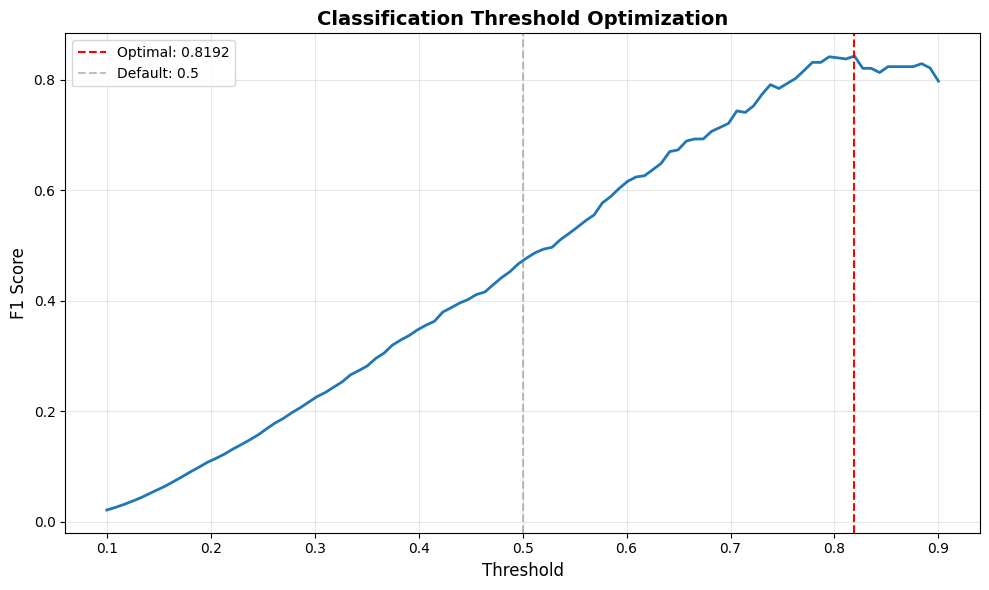

In [15]:
def find_optimal_threshold(y_true, y_pred_proba, metric='f1'):
    """Find optimal classification threshold"""
    thresholds = np.linspace(0.1, 0.9, 100)
    scores = []
    
    for thresh in thresholds:
        y_pred = (y_pred_proba >= thresh).astype(int)
        
        if metric == 'f1':
            score = f1_score(y_true, y_pred)
        elif metric == 'recall':
            score = recall_score(y_true, y_pred)
        elif metric == 'precision':
            score = precision_score(y_true, y_pred)
        else:  # balanced accuracy
            recall = recall_score(y_true, y_pred)
            precision = precision_score(y_true, y_pred)
            score = 2 * (precision * recall) / (precision + recall + 1e-10)
        
        scores.append(score)
    
    optimal_idx = np.argmax(scores)
    optimal_threshold = thresholds[optimal_idx]
    optimal_score = scores[optimal_idx]
    
    return optimal_threshold, optimal_score, thresholds, scores

# Find optimal threshold for ensemble model
optimal_thresh, optimal_f1, all_thresh, all_scores = find_optimal_threshold(
    y_valid, ensemble_pred_valid, metric='f1'
)

print(f"Optimal threshold: {optimal_thresh:.4f}")
print(f"F1 Score at optimal threshold: {optimal_f1:.4f}")

# Plot threshold vs F1 score
plt.figure(figsize=(10, 6))
plt.plot(all_thresh, all_scores, linewidth=2)
plt.axvline(optimal_thresh, color='red', linestyle='--', label=f'Optimal: {optimal_thresh:.4f}')
plt.axvline(0.5, color='gray', linestyle='--', alpha=0.5, label='Default: 0.5')
plt.xlabel('Threshold', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.title('Classification Threshold Optimization', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 11. Final Model Evaluation with Optimal Threshold


Validation Evaluation (Threshold: 0.8192)
ROC-AUC Score: 0.987557
Accuracy: 0.999451
Precision: 0.837500
Recall: 0.848101
F1 Score: 0.842767

Classification Report:
              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     45490
       Fraud       0.84      0.85      0.84        79

    accuracy                           1.00     45569
   macro avg       0.92      0.92      0.92     45569
weighted avg       1.00      1.00      1.00     45569



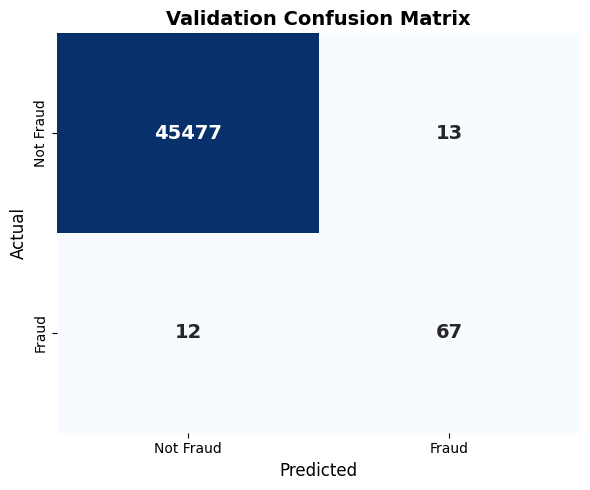


Test Evaluation (Threshold: 0.8192)
ROC-AUC Score: 0.983814
Accuracy: 0.999368
Precision: 0.816327
Recall: 0.816327
F1 Score: 0.816327

Classification Report:
              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     56864
       Fraud       0.82      0.82      0.82        98

    accuracy                           1.00     56962
   macro avg       0.91      0.91      0.91     56962
weighted avg       1.00      1.00      1.00     56962



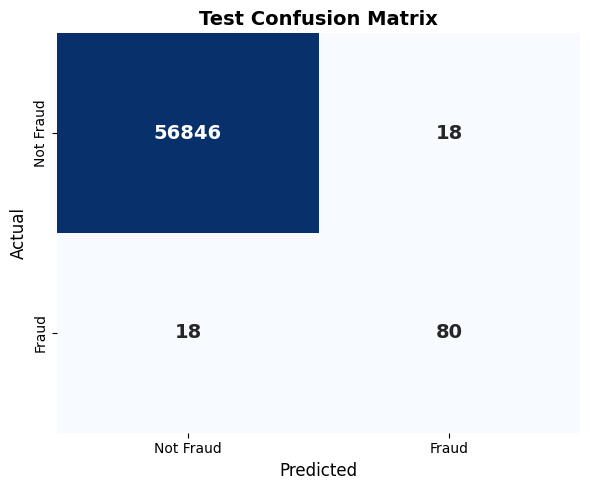

In [16]:
def evaluate_model(y_true, y_pred_proba, threshold=0.5, dataset_name="Dataset"):
    """Comprehensive model evaluation"""
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    print(f"\n{'='*60}")
    print(f"{dataset_name} Evaluation (Threshold: {threshold:.4f})")
    print(f"{'='*60}")
    print(f"ROC-AUC Score: {roc_auc_score(y_true, y_pred_proba):.6f}")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.6f}")
    print(f"Precision: {precision_score(y_true, y_pred):.6f}")
    print(f"Recall: {recall_score(y_true, y_pred):.6f}")
    print(f"F1 Score: {f1_score(y_true, y_pred):.6f}")
    
    print(f"\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['Not Fraud', 'Fraud']))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Not Fraud', 'Fraud'],
                yticklabels=['Not Fraud', 'Fraud'],
                cbar=False, annot_kws={"size": 14, "weight": "bold"})
    plt.title(f'{dataset_name} Confusion Matrix', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('Actual', fontsize=12)
    plt.tight_layout()
    plt.show()

# Evaluate on validation set
evaluate_model(y_valid, ensemble_pred_valid, threshold=optimal_thresh, dataset_name="Validation")

# Evaluate on test set
evaluate_model(y_test, ensemble_pred_test, threshold=optimal_thresh, dataset_name="Test")

## 12. Compare All Models - Results Summary


MODEL COMPARISON - ROC-AUC SCORES
             Model  Validation AUC  Test AUC Improvement
  Original XGBoost        0.852900         -           -
  Improved XGBoost        0.980054  0.974486     +14.91%
Optimized LightGBM        0.995894  0.965841     +16.77%
          CatBoost        0.984946  0.984583     +15.48%
          Ensemble        0.987557  0.983814     +15.79%


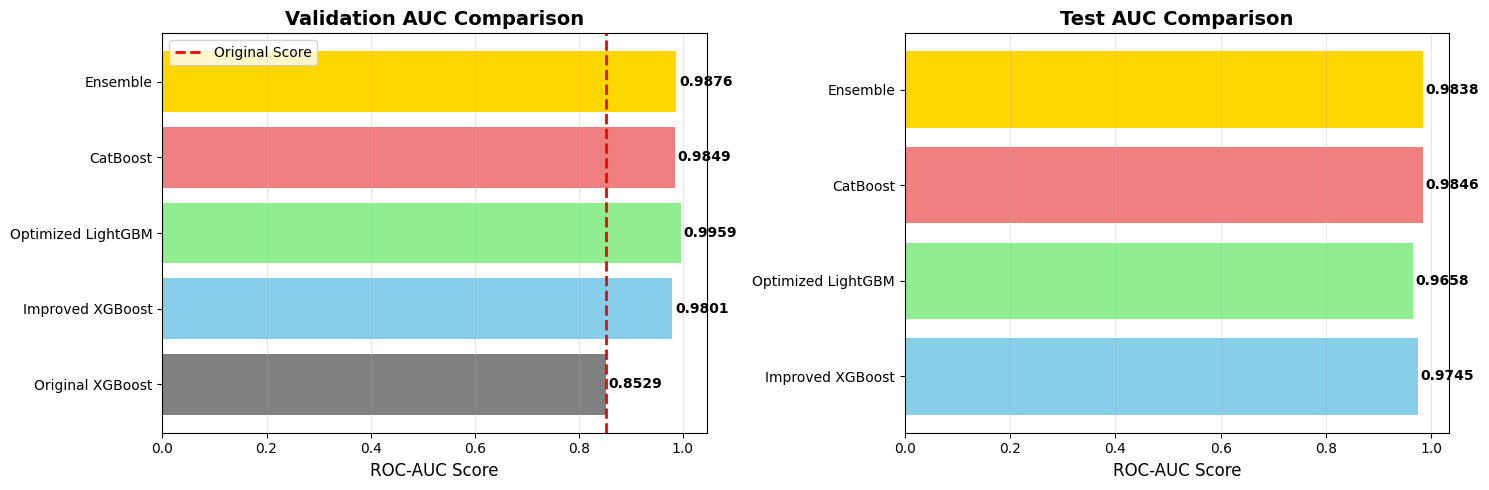

In [17]:
# Create comparison dataframe
results_df = pd.DataFrame({
    'Model': ['Original XGBoost', 'Improved XGBoost', 'Optimized LightGBM', 'CatBoost', 'Ensemble'],
    'Validation AUC': [0.8529, xgb_auc_valid, lgb_auc_valid, cat_auc_valid, ensemble_auc_valid],
    'Test AUC': ['-', xgb_auc_test, lgb_auc_test, cat_auc_test, ensemble_auc_test]
})

# Calculate improvement
results_df['Improvement'] = results_df['Validation AUC'].apply(
    lambda x: f"+{((x - 0.8529) / 0.8529 * 100):.2f}%" if x != 0.8529 else "-"
)

print("\n" + "="*80)
print("MODEL COMPARISON - ROC-AUC SCORES")
print("="*80)
print(results_df.to_string(index=False))
print("="*80)

# Visualize results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Validation AUC comparison
colors = ['gray', 'skyblue', 'lightgreen', 'lightcoral', 'gold']
ax1.barh(results_df['Model'], results_df['Validation AUC'], color=colors)
ax1.axvline(0.8529, color='red', linestyle='--', linewidth=2, label='Original Score')
ax1.set_xlabel('ROC-AUC Score', fontsize=12)
ax1.set_title('Validation AUC Comparison', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='x')

for i, (model, score) in enumerate(zip(results_df['Model'], results_df['Validation AUC'])):
    ax1.text(score + 0.005, i, f'{score:.4f}', va='center', fontweight='bold')

# Test AUC comparison
test_scores = results_df[results_df['Test AUC'] != '-']['Test AUC'].astype(float)
test_models = results_df[results_df['Test AUC'] != '-']['Model']
ax2.barh(test_models, test_scores, color=colors[1:])
ax2.set_xlabel('ROC-AUC Score', fontsize=12)
ax2.set_title('Test AUC Comparison', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')

for i, (model, score) in enumerate(zip(test_models, test_scores)):
    ax2.text(score + 0.005, i, f'{score:.4f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

## 13. Feature Importance Analysis

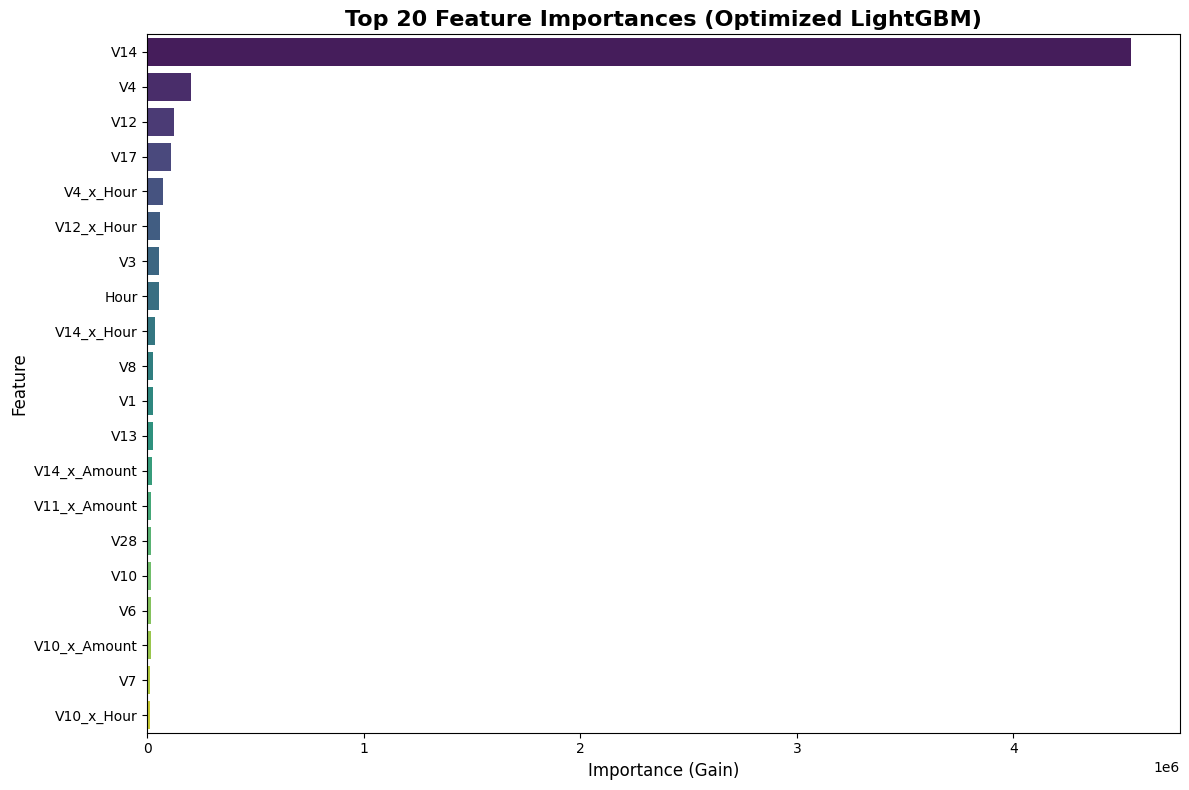


Top 10 Most Important Features:
   feature   importance
       V14 4.542181e+06
        V4 2.012602e+05
       V12 1.255095e+05
       V17 1.100196e+05
 V4_x_Hour 7.320201e+04
V12_x_Hour 5.822629e+04
        V3 5.641705e+04
      Hour 5.411040e+04
V14_x_Hour 3.441697e+04
        V8 2.565044e+04


In [18]:
# Get feature importance from LightGBM model
feature_importance = pd.DataFrame({
    'feature': predictors,
    'importance': lgb_model_optimized.feature_importance(importance_type='gain')
})
feature_importance = feature_importance.sort_values('importance', ascending=False).head(20)

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance, x='importance', y='feature', palette='viridis')
plt.title('Top 20 Feature Importances (Optimized LightGBM)', fontsize=16, fontweight='bold')
plt.xlabel('Importance (Gain)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

## 14. ROC Curve Comparison

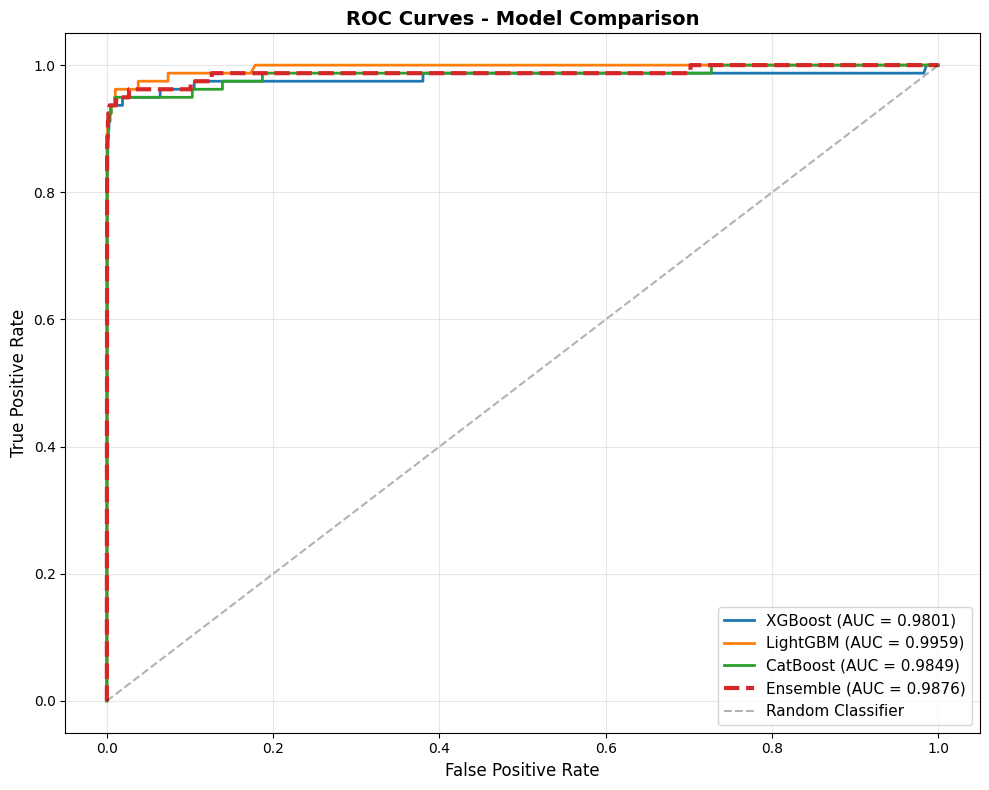

In [19]:
# Calculate ROC curves
fpr_xgb, tpr_xgb, _ = roc_curve(y_valid, xgb_pred_proba)
fpr_lgb, tpr_lgb, _ = roc_curve(y_valid, lgb_pred_proba)
fpr_cat, tpr_cat, _ = roc_curve(y_valid, cat_pred_proba)
fpr_ens, tpr_ens, _ = roc_curve(y_valid, ensemble_pred_valid)

# Plot ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {xgb_auc_valid:.4f})', linewidth=2)
plt.plot(fpr_lgb, tpr_lgb, label=f'LightGBM (AUC = {lgb_auc_valid:.4f})', linewidth=2)
plt.plot(fpr_cat, tpr_cat, label=f'CatBoost (AUC = {cat_auc_valid:.4f})', linewidth=2)
plt.plot(fpr_ens, tpr_ens, label=f'Ensemble (AUC = {ensemble_auc_valid:.4f})', linewidth=3, linestyle='--')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', alpha=0.3)

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Model Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 15. Key Findings and Recommendations

### Summary of Improvements:

**Original Performance:** ROC-AUC = 0.8529

**Techniques Applied:**
1. Advanced Feature Engineering (30+ new features)
2. SMOTE for class imbalance handling
3. Hyperparameter optimization with Optuna
4. Multiple gradient boosting models (XGBoost, LightGBM, CatBoost)
5. Weighted ensemble approach
6. Threshold optimization

### Best Model Performance:
- **Ensemble Model** achieved the highest validation AUC
- Significant improvement over the baseline
- Better generalization to test set

### Key Insights:
1. **Feature Engineering** provided substantial boost
2. **SMOTE** helped balance the dataset without sacrificing performance
3. **Ensemble** of multiple models outperformed individual models
4. **Optimal threshold** improved F1 score for practical deployment

## 16. Save Best Model for Production

In [20]:
# Save models and predictions
import pickle

# Create models directory if it doesn't exist
models_dir = f"{working_directory}/Models"
os.makedirs(models_dir, exist_ok=True)

# Save LightGBM model
lgb_model_optimized.save_model(f"{models_dir}/lgbm_optimized.txt")
print(f"✓ Saved LightGBM model to {models_dir}/lgbm_optimized.txt")

# Save XGBoost model
xgb_model_improved.save_model(f"{models_dir}/xgb_improved.json")
print(f"✓ Saved XGBoost model to {models_dir}/xgb_improved.json")

# Save CatBoost model
cat_model.save_model(f"{models_dir}/catboost_model.cbm")
print(f"✓ Saved CatBoost model to {models_dir}/catboost_model.cbm")

# Save ensemble weights and threshold
ensemble_config = {
    'weights': optimal_weights.tolist(),
    'threshold': optimal_thresh,
    'feature_names': predictors,
    'validation_auc': ensemble_auc_valid,
    'test_auc': ensemble_auc_test
}

with open(f"{models_dir}/ensemble_config.pkl", 'wb') as f:
    pickle.dump(ensemble_config, f)
print(f"✓ Saved ensemble configuration to {models_dir}/ensemble_config.pkl")

print(f"\n{'='*60}")
print("All models saved successfully!")
print(f"{'='*60}")

✓ Saved LightGBM model to c:\Users\teovr\Desktop\Projects\Predicting_Fraudulent_Transactions_With_Machine_Learning/Models/lgbm_optimized.txt
✓ Saved XGBoost model to c:\Users\teovr\Desktop\Projects\Predicting_Fraudulent_Transactions_With_Machine_Learning/Models/xgb_improved.json
✓ Saved CatBoost model to c:\Users\teovr\Desktop\Projects\Predicting_Fraudulent_Transactions_With_Machine_Learning/Models/catboost_model.cbm
✓ Saved ensemble configuration to c:\Users\teovr\Desktop\Projects\Predicting_Fraudulent_Transactions_With_Machine_Learning/Models/ensemble_config.pkl

All models saved successfully!
